# <center> EE4708: Data Analytics Laboratory </center>
# <center> Assignment 4: Decision Trees </center>

## <center> Gautham Govind A: EE19B022 </center>

### Loading necessary packages

In [84]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.utils import resample 

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import xgboost as xgb

Setting suitable font size and figure size for plots:

In [5]:
plt.rcParams.update({'font.size': 17})
plt.rcParams['figure.figsize'] = (10, 7)

### Loading the dataset

A brief look at the dataset reveals that column names are actually missing from the excel file. We add them manually:

In [6]:
column_names = ['buying','maint','doors','persons','lug_boot','safety','target']
df = pd.read_excel('car_evaluation.xlsx', header = None, names = column_names)

In [7]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   target    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Looks like we don't have any missing values.

###  Exploratory Data Analysis

We first look at how the target class is distributed:

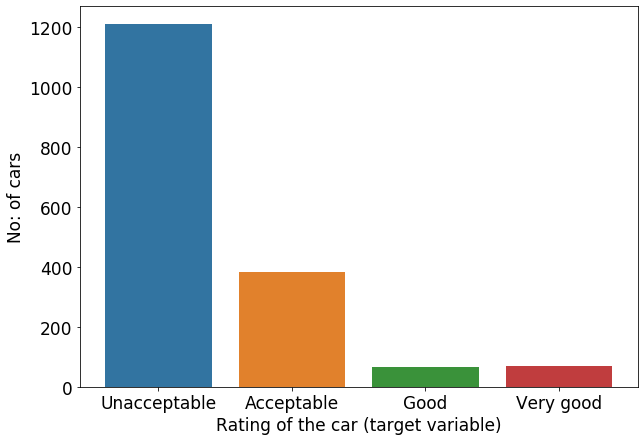

In [9]:
# We set the names of the classes as follows:
# unacc - Unacceptable
# acc   - Acceptable
# good  - Good
# vgood - Very good  
target_ratings = ['Unacceptable', 'Acceptable', 'Good', 'Very good']

ax = sns.countplot(data = df, x = 'target')
ax.set_xlabel('Rating of the car (target variable)')
ax.set_ylabel('No: of cars')
ax.set_xticklabels(target_ratings)
plt.autoscale()
plt.savefig("Figures/target_dist.png", bbox_inches = "tight")

The number of cars belonging to the target class 'unacc' are much higher than other categores. Hence, our dataset is inherently skewed. We should keep this in mind while building the decision tree.

Clearly, we have only categorical variables. We analyze the impact of each variable on the target through countplots.

#### Buying Price

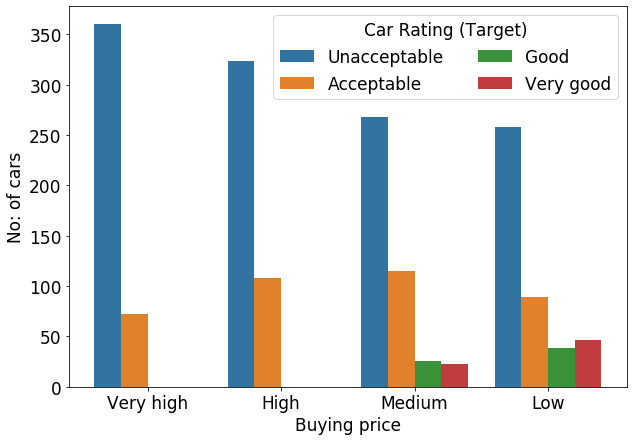

In [10]:
buying_price = ['Very high', 'High', 'Medium', 'Low']

ax = sns.countplot(data = df, x = 'buying', hue = 'target')
ax.set_xlabel('Buying price')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(buying_price)
plt.autoscale()
plt.savefig("Figures/bp.png", bbox_inches = "tight")

Observations:
- Cars with high and very high have a large proportion of unacceptable vehicles
- Medium and low priced cars have representation from all categories

These observations make sense intuitively, because lower price vehicles will generally be more accessible to a larger section of the population.

#### Maintenance price

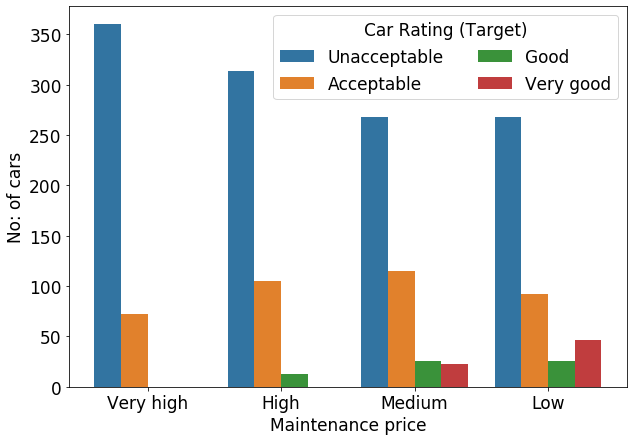

In [11]:
maintain_price = ['Very high', 'High', 'Medium', 'Low']

ax = sns.countplot(data = df, x = 'maint', hue = 'target')
ax.set_xlabel('Maintenance price')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(maintain_price)
plt.autoscale()
plt.savefig("Figures/mp.png", bbox_inches = "tight")

The plot obtained is largely similar to the plot for buying price. This again makes sense intuitively since cars with high/very high maintenance charges would be mostly unacceptable to a large section of the population.

#### Number of Doors

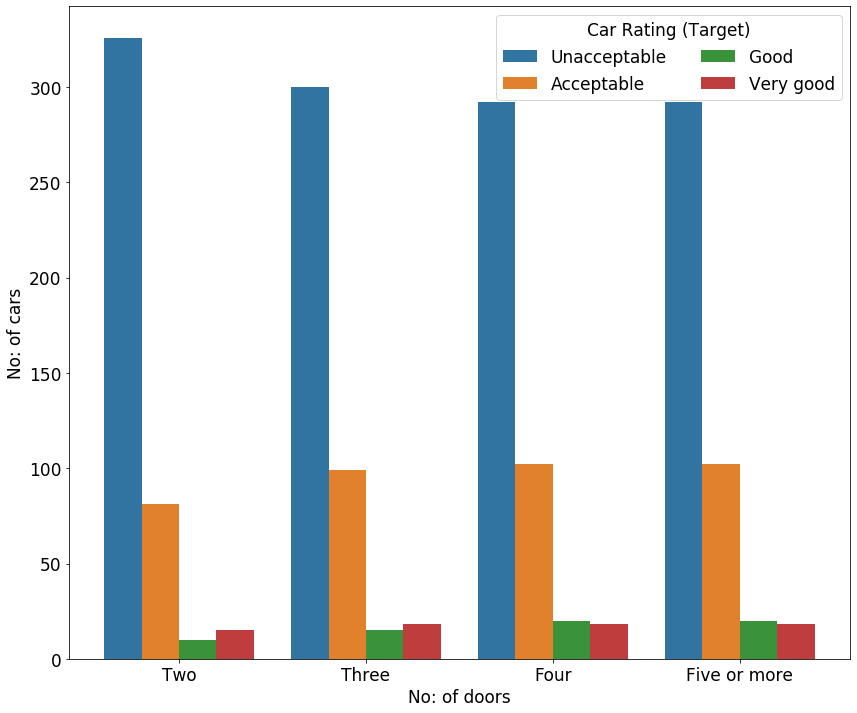

In [12]:
door_count = ["Two", 'Three', 'Four', 'Five or more']

plt.figure(figsize = (14, 12))
ax = sns.countplot(data = df, x = 'doors', hue = 'target')
ax.set_xlabel('No: of doors')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(door_count)
plt.autoscale()
plt.savefig("Figures/nd.png", bbox_inches = "tight")

The distribution is similar for all categories of the variable respresenting the number of doors. This implies that no:of doors is not really a deciding factor as far as rating is concerned.

#### Passenger capacity

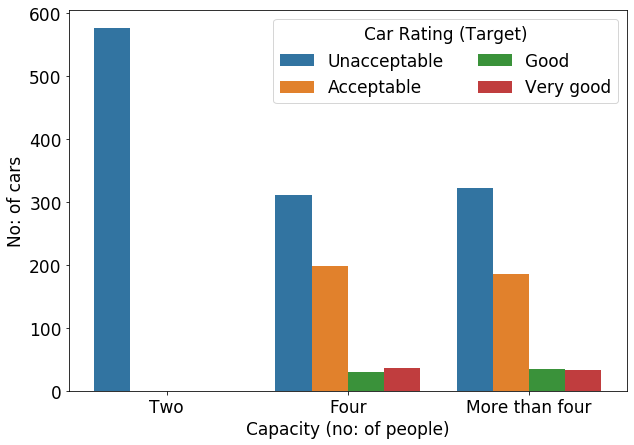

In [13]:
capacity = ['Two', 'Four', 'More than four']

ax = sns.countplot(data = df, x = 'persons', hue = 'target')
ax.set_xlabel('Capacity (no: of people)')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(capacity)
plt.autoscale()
plt.savefig("Figures/cp.png", bbox_inches = "tight")

Observations:
- Cars that can accomodate only two people are all unacceptable
- Cars which can accomodate four and more than four have similar distriubtions

Intuitively, it seems fair that people find only cars which have atleast 4 seats to be acceptable.

#### Size of luggage boot

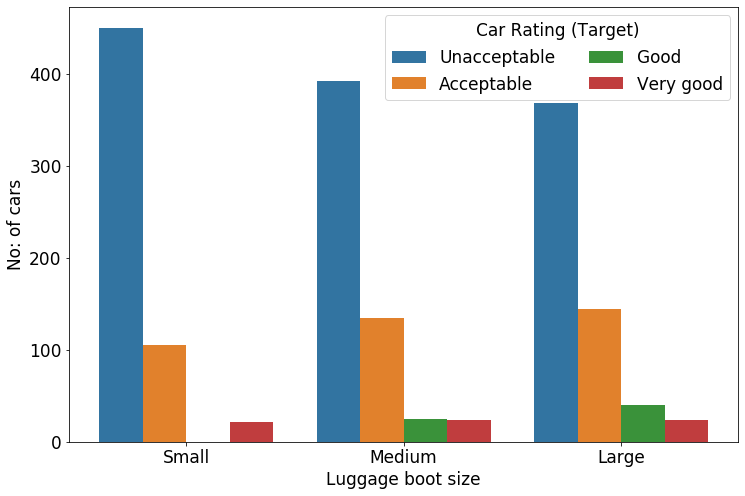

In [14]:
boot_size = ['Small', 'Medium', 'Large']

plt.figure(figsize = (12, 8))
ax = sns.countplot(data = df, x = 'lug_boot', hue = 'target')
ax.set_xlabel('Luggage boot size')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(boot_size)
plt.autoscale()
plt.savefig("Figures/lgp.png", bbox_inches = "tight")

We observe that small-sized luggage boot has a relatively larger proportion of unacceptbale cars, which is what we expect inuitively anyway.

#### Safety rating

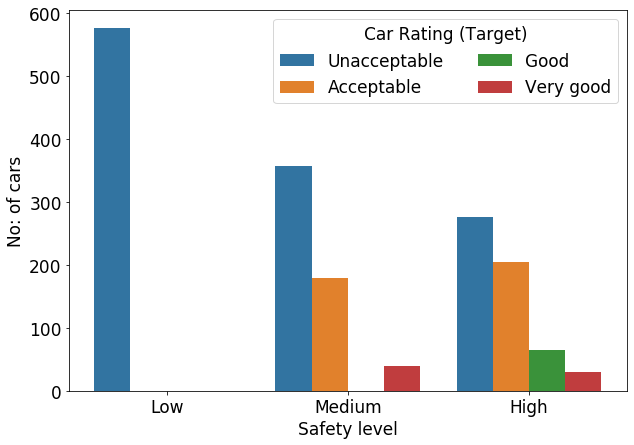

In [15]:
safety_lvl = ['Low', 'Medium', 'High']

ax = sns.countplot(data = df, x = 'safety', hue = 'target')
ax.set_xlabel('Safety level')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(safety_lvl)
plt.autoscale()
plt.savefig("Figures/sfp.png", bbox_inches = "tight")

Observations:
- All low safety cars are unacceptable
- As safety level increases, proportion of unacceptbale cars decreases

Again this makes sense intuitively as people would prefer cars with high safety levels over low safety levels.

### Encoding the variables

Since all the variables are categorical, it is necessary to encode them.

We note that all the variables have an inherent ordering. Hence, it makes sense to use ordinal encoding.

In [16]:
# Buying price
bp_labels = {'low':0, 'med':1, 'high':2, 'vhigh':3}

# Maintenance price
mp_labels = {'low':0, 'med':1, 'high':2, 'vhigh':3}

# No: of doors
door_labels = {2:0, 3:1, 4:2, "5more":3}

# Passenger capacity
capacity_labels = {2:0, 4:1, 'more':2}

# Luggage boot size
boot_labels = {'small':0, 'med':1, 'big':2}

# Safety level
safety_labels = {'low':0, 'med':1, 'high':2}

# Target
target_labels = {'unacc':0, 'acc':1, 'good':2, 'vgood':3}

We perform label encoding:

In [17]:
df['buying'] = df['buying'].map(bp_labels)
df['maint'] = df['maint'].map(mp_labels)
df['doors'] = df['doors'].map(door_labels)
df['persons'] = df['persons'].map(capacity_labels)
df['lug_boot'] = df['lug_boot'].map(boot_labels)
df['safety'] = df['safety'].map(safety_labels)
df['target'] = df['target'].map(target_labels)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   buying    1728 non-null   int64
 1   maint     1728 non-null   int64
 2   doors     1728 non-null   int64
 3   persons   1728 non-null   int64
 4   lug_boot  1728 non-null   int64
 5   safety    1728 non-null   int64
 6   target    1728 non-null   int64
dtypes: int64(7)
memory usage: 94.6 KB


### Splitting dataset into training, validation and test sets

In [19]:
X = df.drop('target', axis = 1)
y = df['target']

Train - (Val+Test) split:

In [20]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify = y)

We ensure that target class proportion is preserved.

In [21]:
(y_train == 0).sum()/len(y_train)

0.7007722007722008

In [22]:
(y_val_test == 0).sum()/len(y_val_test)

0.6994219653179191

Val - Test split:

In [23]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 42, stratify = y_val_test)

We ensure that target class proportion is preserved.

In [24]:
(y_val == 0).sum()/len(y_val)

0.6994219653179191

In [25]:
(y_test == 0).sum()/len(y_test)

0.6994219653179191

Displaying the dimensions:


In [26]:
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (1036, 6)
Validation set: (346, 6)
Test set: (346, 6)


Making a combined training set for use after validation:

In [27]:
X_train_full = pd.concat([X_train, X_val])
y_train_full = np.concatenate((y_train, y_val),axis= 0)

X_train_full.reset_index(drop = True, inplace  = True)

#### Implementing decision tree

We recall the important observation that the target class does not have a balanced distributions. Hence, it is essential to weigh each class inversly with respect to its freqency. This is done by setting class_weight = 'balanced' in the classifier definition.

#### Model 1

First, we implement an unrestricted tree with no restrictions on the depth or number of nodes.

In [28]:
clf1 = DecisionTreeClassifier(class_weight = 'balanced', random_state = 42)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

Checking the accuracy:

In [29]:
print('Train Accuracy: ', clf1.score(X_train,y_train)*100)
print('Validation Accuracy: ',clf1.score(X_val, y_val))

Train Accuracy:  100.0
Validation Accuracy:  0.9566473988439307


An accuracy of 100% on training set! Clearly, this indicates overfitting. Let us look at the depth:

In [30]:
print('Tree Depth: ', clf1.get_depth())

Tree Depth:  12


Plotting the tree:

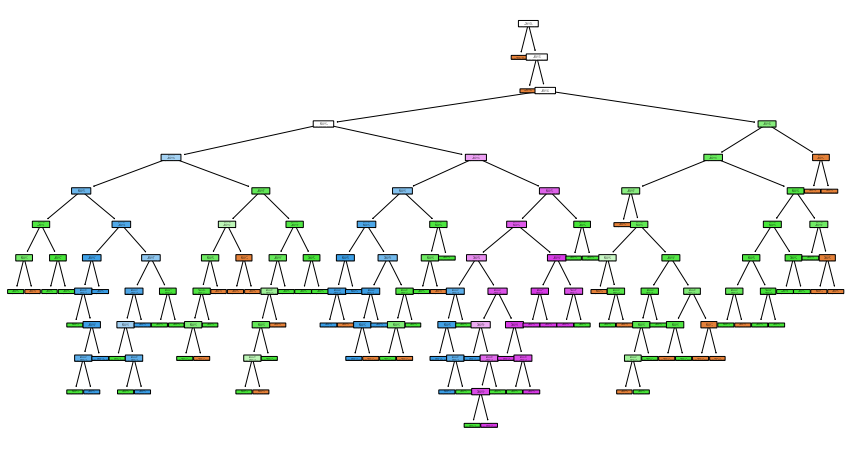

In [31]:
plt.figure(figsize = (15,8))
plot_tree(clf1, rounded = True, filled = True)
plt.show()

Metrics on the validation set:

In [32]:
cr1 = classification_report(y_val, clf1.predict(X_val), output_dict=True)
pd.DataFrame(cr1).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.952806,0.956235
recall,0.892324,0.956647
f1-score,0.920520,0.955759


#### Model 2: Controlling depth - Pruning

Typically trees which overfit tend to have more depth than required. We examine the evolution of accuracy v/s depth:

In [33]:
depth_clf = []
depth_list = list(range(1, 13))

for el in depth_list:
    
    cl = DecisionTreeClassifier(class_weight = 'balanced', max_depth = el, random_state = 42)
    cl.fit(X_train, y_train)
    
    depth_clf.append(cl)

In [34]:
depth_f1 = [f1_score(clf.predict(X_val), y_val, average = 'weighted') for clf in depth_clf]
print("Highest F1 score for a tree depth = ",depth_list[np.argmax(depth_f1)])

Highest F1 score for a tree depth =  9


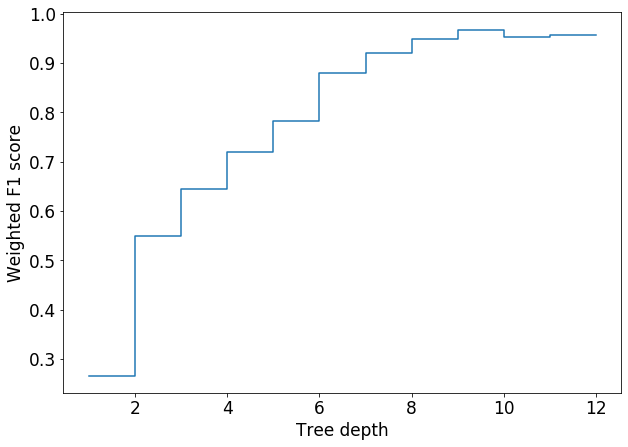

In [35]:
plt.plot(depth_list, depth_f1, drawstyle = 'steps-post')
plt.xlabel("Tree depth")
plt.ylabel("Weighted F1 score")
plt.savefig("Figures/depth_f1.png")

We obtain highest validation accuracy for depth = 9. 
Let us check the statistics for this model:

In [36]:
clf2 = depth_clf[np.argmax(depth_f1)]

In [37]:
cr2 = classification_report(y_val, clf2.predict(X_val), output_dict=True)
pd.DataFrame(cr2).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.900138,0.971120
recall,0.951889,0.968208
f1-score,0.921115,0.968381


Clearly, this model outperforms model 1.

#### Model 3: Bagging

We check if instead of pruning, bagging on a large number of trees can improve performance:

We create a class for bagged trees:

In [38]:
# Performing bagging of decision trees
# B                - No: of trees to be considered
# train_fraction   - Fraction of the training set which should be randomly sampled for each tree


class Bagged:
    
    def __init__(self, B, train_fraction):
        
        self.train_fraction = train_fraction
        self.B = B
    
    def fit(self, df_train):
        
        self.bag = list() 
        n_size = int(len(df_train) * self.train_fraction)
        
        for i in range(self.B):

            # Perform random sampling of training data
            train_data = resample(df_train, n_samples = n_size) 
            train_data.reset_index(drop = True, inplace = True)

            # Fit the tree
            model = DecisionTreeClassifier(class_weight = 'balanced', random_state = 42)
            model.fit(train_data.drop('target',axis = 1), train_data['target']) 
            
            self.bag.append(model)  
        
        
    def predict(self,X):
        
        pred_arr = []
        for clf in self.bag:
            pred_arr.append(clf.predict(X)) 
        
        # Take themost voted class as the predition
        bag_pred = stats.mode(pred_arr, axis = 0)[0]
        bag_pred = bag_pred.reshape(-1,1)
        
        return bag_pred
    
    def score(self,X,y):

        return accuracy_score(y, self.predict(X))
                
    def returnbag(self):
        
        return self.bag

In [39]:
df_train = X_train.copy()
df_train['target'] = y_train

We fix the fraction to be used in bootstrapping to 0.5.
We vary the no: of trees and compare the weighted f1 score:

In [40]:
frac = 0.5
B_vals = list(range(10, 150, 20))
B_clf = []

for B in B_vals:
    
    clf = Bagged(B, frac)
    clf.fit(df_train)
    
    B_clf.append(clf)

In [41]:
B_f1 = [f1_score(clf.predict(X_val), y_val, average = 'weighted') for clf in B_clf]
print("Highest f1 score for no: of trees = ", B_vals[np.argmax(B_f1)])

/tmp/ipykernel_113301/469136286.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bag_pred = stats.mode(pred_arr, axis = 0)[0]
/tmp/ipykernel_113301/469136286.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bag_pred = stats.mode(pred_arr, axis = 0)[0]
/tmp

Highest f1 score for no: of trees =  50


/tmp/ipykernel_113301/469136286.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bag_pred = stats.mode(pred_arr, axis = 0)[0]


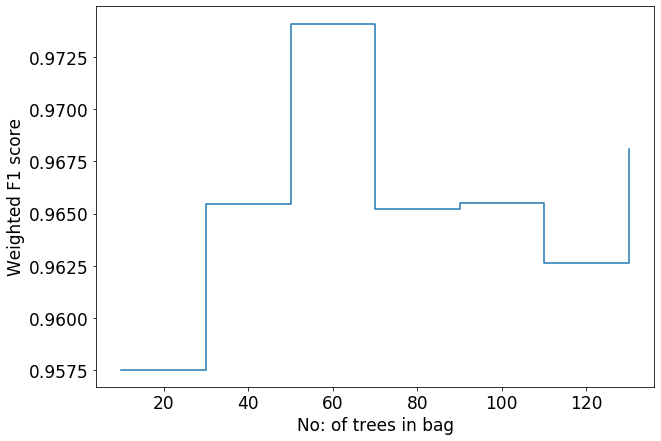

In [42]:
plt.plot(B_vals, B_f1, drawstyle = 'steps-post')
plt.xlabel("No: of trees in bag")
plt.ylabel("Weighted F1 score")
plt.savefig("Figures/b_f1.png")

In [43]:
clf3 = B_clf[np.argmax(B_f1)]

Evaluating the performance:

In [44]:
cr3 = classification_report(y_val, clf3.predict(X_val), output_dict=True)
pd.DataFrame(cr3).loc[:, ['macro avg', 'weighted avg']][:-1]

/tmp/ipykernel_113301/469136286.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bag_pred = stats.mode(pred_arr, axis = 0)[0]


,macro avg,weighted avg
precision,0.916271,0.974200
recall,0.931375,0.973988
f1-score,0.922343,0.973861


Although this performs well, model 2 is better. So we choose the pruned model as the final model.

We train it on the whole training data:

In [45]:
clf_best = DecisionTreeClassifier(class_weight = 'balanced', max_depth = np.argmax(depth_f1), random_state = 42)
clf_best.fit(X_train_full, y_train_full)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42)

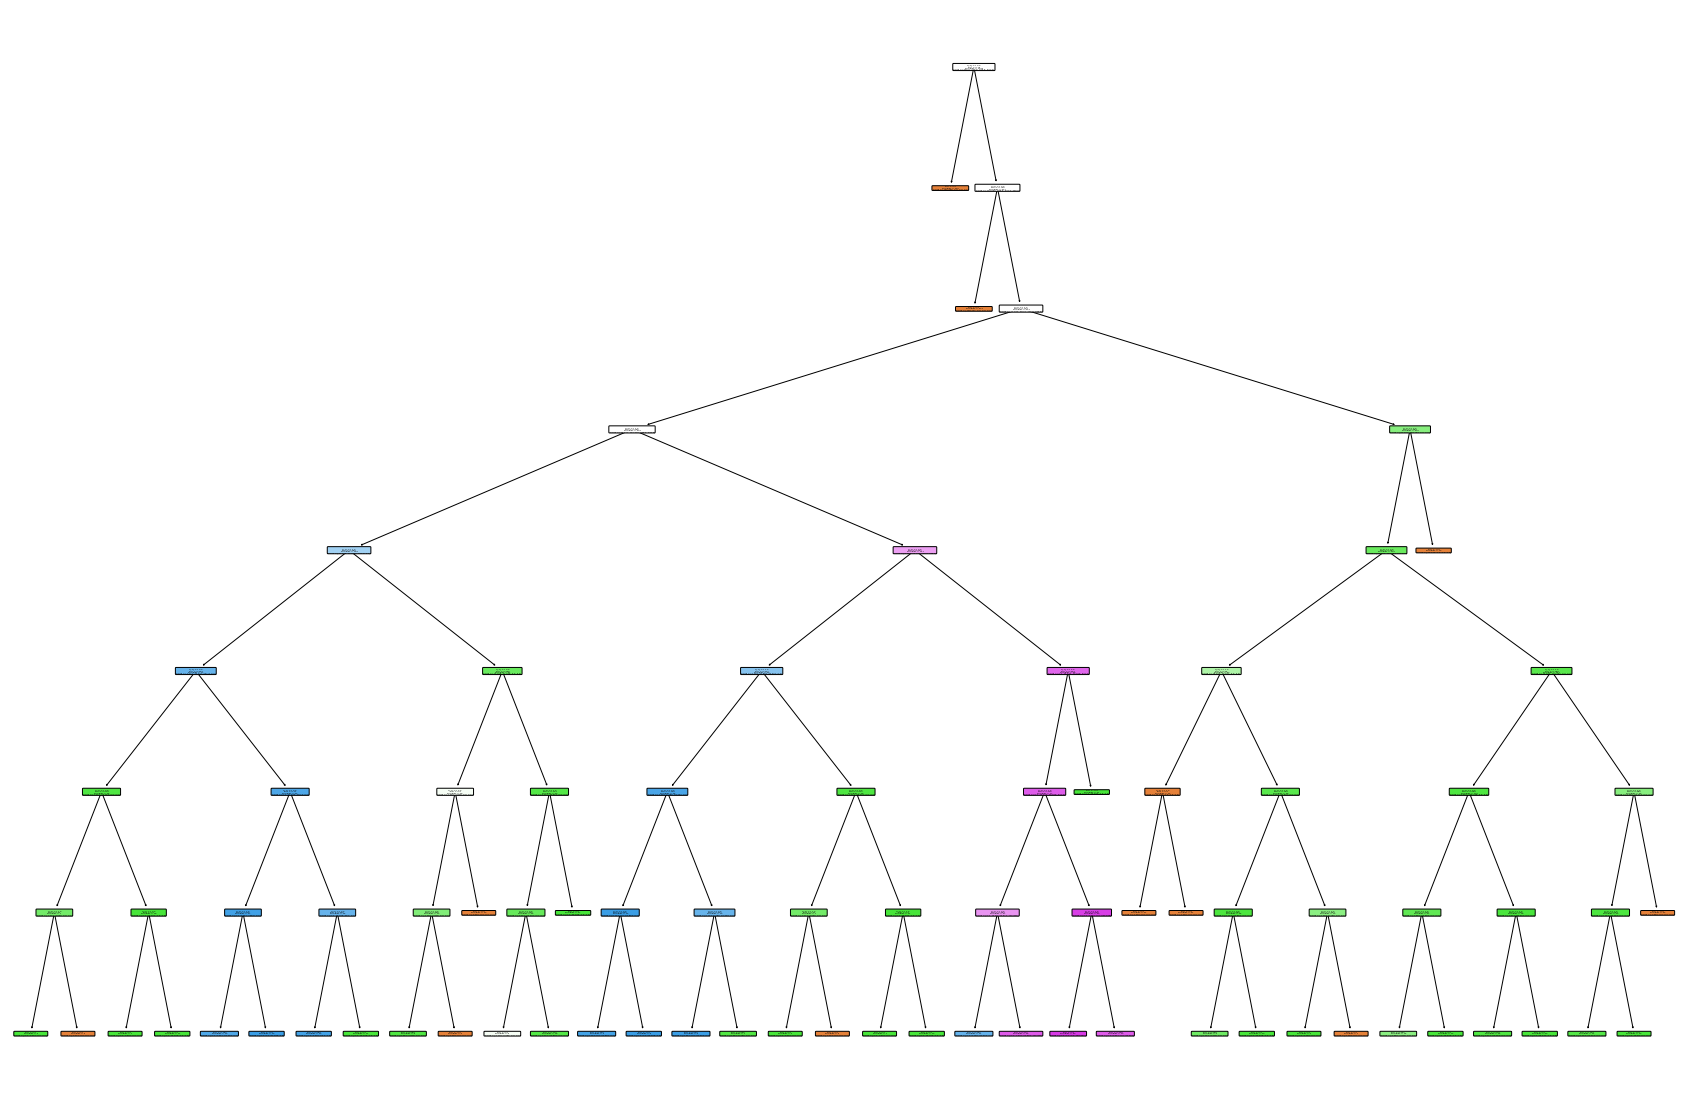

<Figure size 720x504 with 0 Axes>

In [46]:
plt.figure(figsize = (30,20))
plot_tree(clf_best, rounded = True, filled = True)
plt.show()
plt.savefig("Figures/lol.png")

Metrics and Confusion matrix for final model:

In [47]:
cr_final = classification_report(y_test, clf_best.predict(X_test), output_dict=True)
pd.DataFrame(cr_final).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.896465,0.972222
recall,0.960744,0.968208
f1-score,0.922977,0.969298


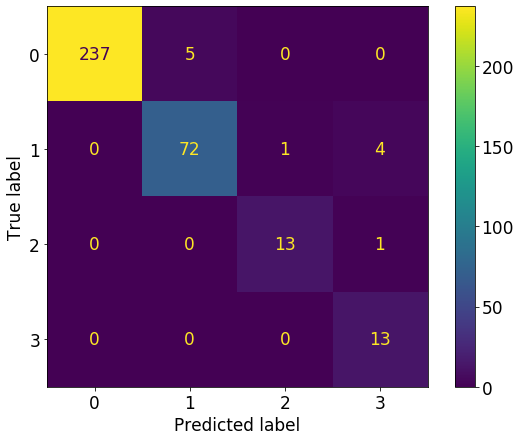

In [48]:
plot_confusion_matrix(clf_best, X_test, y_test)
plt.grid(False)
plt.savefig('Figures/cfmatrix')

We can see the importance of features through feature importance scores:

In [49]:
feature_scores = pd.Series(clf_best.feature_importances_, index=X_train_full.columns).sort_values(ascending=False)
print(feature_scores)

safety      0.263699
maint       0.189718
lug_boot    0.179121
buying      0.171911
persons     0.153082
doors       0.042468
dtype: float64


Safety is the most important feature, whereas no: of doors is the least important feature, which agrees with our initial exploratory analysis

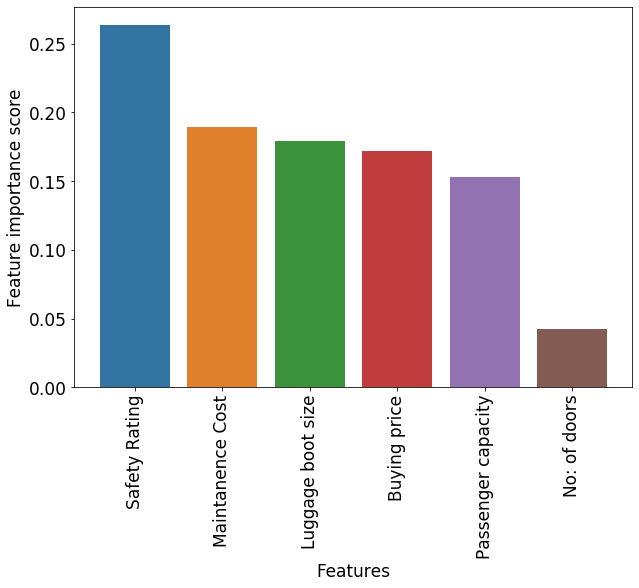

In [50]:
ax = sns.barplot(x = feature_scores.index, y = feature_scores, orient='v')
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance score')
ax.set_xticklabels(['Safety Rating', 'Maintanence Cost', 'Luggage boot size', 'Buying price', 'Passenger capacity', 'No: of doors'])
plt.xticks(rotation = 90)
plt.grid(False)
plt.autoscale()
plt.savefig('Figures/feature_imp.png', bbox_inches = "tight")

### Benchmarking using XGBoost

In [51]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

Parameter space for searching for xgboost:

In [76]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [1.0],
        'max_depth': [4, 5, 6]
        }

In [77]:
xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 1000, objective='binary:logistic',
                 nthread=1)

In [78]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 10)

random_search = GridSearchCV(estimator = xgb, param_grid=params,  scoring='f1_weighted', n_jobs=-1, cv=skf.split(X_train_full,y_train_full), verbose=3)

start_time = timer(None) 
random_search.fit(X_train_full, y_train_full)
timer(start_time)

Fitting 3 folds for each of 135 candidates, totalling 405 fits

 Time taken: 0 hours 3 minutes and 28.05 seconds.


In [79]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
              num_parallel_tree=1, objective='multi:softprob', ...)


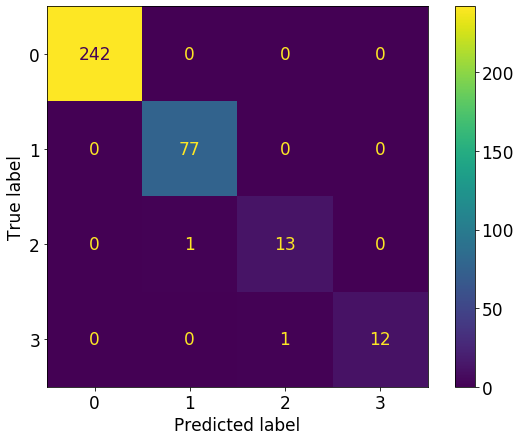

In [82]:
plot_confusion_matrix(random_search, X_test, y_test)
plt.grid(False)
plt.savefig('Figures/cfmatrix_xg.png')

In [83]:
cr_xg = classification_report(y_test, random_search.predict(X_test), output_dict=True)
pd.DataFrame(cr_xg).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.978938,0.994257
recall,0.962912,0.994220
f1-score,0.970530,0.994171


[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.972 total time=   3.7s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0;, score=0.957 total time=   3.2s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.936 total time=   3.1s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.976 total time=   4.3s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.954 total time=   3.7s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.940 total time=   3.2s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.937 total time=   3.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0.8;, score=0.983 total ti

[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=1.0;, score=0.963 total time=   3.1s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=1.0;, score=0.968 total time=   3.2s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0;, score=0.955 total time=   3.1s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0;, score=0.933 total time=   2.8s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.983 total time=   4.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.983 total time=   3.8s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.940 total time=   3.4s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0.6;, score=0.980 total tim

[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8;, score=0.976 total time=   3.5s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=0.8;, score=0.956 total time=   3.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6;, score=0.958 total time=   3.1s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.976 total time=   4.4s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.960 total time=   3.7s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.907 total time=   3.3s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.941 total time=   3.3s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1, subsample=1.0;, score=0.978 total ti

[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.974 total time=   3.6s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=0.6;, score=0.974 total time=   3.4s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.967 total time=   3.1s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.980 total time=   4.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.974 total time=   3.6s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.970 total time=   3.7s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0.6;, score=0.974 total time=   5.0s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=5, subsample=0.6;, score=0.956 total time

In [114]:
feat_scores = random_search.best_estimator_.get_booster().get_score()
inv_dict = {}

for key, val in feat_scores.items():
    inv_dict[val] = key
    
feat_names = list(inv_dict.keys())
feat_names = sorted(feat_names)[::-1]

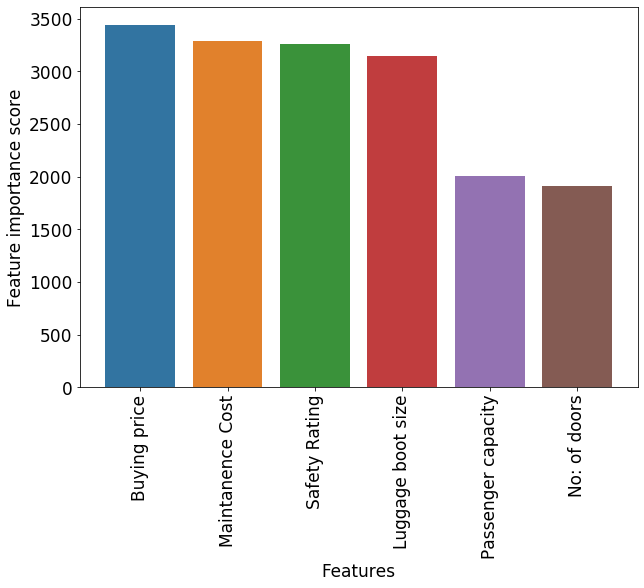

In [119]:
ax = sns.barplot(x = [inv_dict[el] for el in feat_names], y = feat_names, orient='v')
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance score')
ax.set_xticklabels(['Buying price',  'Maintanence Cost', 'Safety Rating', 'Luggage boot size', 'Passenger capacity', 'No: of doors'])
plt.xticks(rotation = 90)
plt.grid(False)
plt.autoscale()
plt.savefig('Figures/feature_imp_xg.png', bbox_inches = "tight")